In [3]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt


In [4]:
def check_intersection(contour1, contour2):
    """
    Проверяет пересечение двух контуров.

    :param contour1: Первый контур.
    :param contour2: Второй контур.
    :return: True, если есть пересечение, иначе False.
    """
    if contour1 is None or contour2 is None:
        return False

    if len(contour1) == 0 or len(contour2) == 0:
        return False

    # Преобразуем контуры в выпуклые оболочки
    hull1 = cv2.convexHull(contour1.astype(np.float32))
    hull2 = cv2.convexHull(contour2.astype(np.float32))

    # Проверка пересечения выпуклых оболочек
    ret, _ = cv2.intersectConvexConvex(hull1, hull2)

    return ret > 0

def intersection_area(contour1, contour2):
    """
    Вычисляет площадь пересечения двух контуров.
    
    :param contour1: Первый контур.
    :param contour2: Второй контур.
    :return: Площадь пересечения.
    """
    # Создаем пустое изображение
    img = np.zeros((1000, 1000), dtype=np.uint8)
    
    # Рисуем первый контур
    cv2.fillPoly(img, [contour1.astype(np.int32)], 1)
    
    # Рисуем второй контур
    cv2.fillPoly(img, [contour2.astype(np.int32)], 1)
    
    # Считаем количество пересечений
    intersection = np.sum(img == 2)
    
    return intersection

def find_intersections(leftmost_contours, circle_contours):
    intersections = []

    for left_contour in leftmost_contours:
        for circle_contour in circle_contours:
            if check_intersection(left_contour, circle_contour):
                intersections.append(left_contour)
                break

    return intersections

def remove_intersections(counters, filter_counters):
    not_intersections = []

    for counter in counters:
        is_intersection = False
        for filter_counter in filter_counters:
            if check_intersection(counter, filter_counter):
                is_intersection = True
                break
        if not is_intersection:
            not_intersections.append(counter)
    return not_intersections

def get_counters_after_counter(counters, counter, axis='y'):
    """
    Возвращает контуры, находящиеся после заданного контура вдоль указанной оси.
    
    :param counters: Список контуров.
    :param counter: Заданный контур.
    :param axis: Ось ('x' или 'y'), вдоль которой проверяется положение контуров.
    :return: Список контуров, находящихся после заданного контура вдоль указанной оси.
    """
    # Определяем координаты заданного контура вдоль указанной оси
    if axis == 'y':
        _, y, _, h = cv2.boundingRect(counter)
        threshold = y + h
    elif axis == 'x':
        x, _, w, _ = cv2.boundingRect(counter)
        threshold = x + w
    else:
        raise ValueError("Invalid axis. Use 'x' or 'y'.")
    
    # Отфильтровываем контуры, которые находятся после заданного контура вдоль указанной оси
    result = []
    for cnt in counters:
        if axis == 'y':
            _, y, _, _ = cv2.boundingRect(cnt)
            if y > threshold:
                result.append(cnt)
        elif axis == 'x':
            x, _, _, _ = cv2.boundingRect(cnt)
            if x > threshold:
                result.append(cnt)
    
    return result

def get_counters_before_counter(counters, counter, axis='y'):
    """
    Возвращает контуры, находящиеся перед заданным контуром вдоль указанной оси.
    
    :param counters: Список контуров.
    :param counter: Заданный контур.
    :param axis: Ось ('x' или 'y'), вдоль которой проверяется положение контуров.
    :return: Список контуров, находящихся перед заданным контуром вдоль указанной оси.
    """
    # Определяем координаты заданного контура вдоль указанной оси
    if axis == 'y':
        _, y, _, _ = cv2.boundingRect(counter)
        threshold = y
    elif axis == 'x':
        x, _, _, _ = cv2.boundingRect(counter)
        threshold = x
    else:
        raise ValueError("Invalid axis. Use 'x' or 'y'.")
    
    # Отфильтровываем контуры, которые находятся перед заданным контуром вдоль указанной оси
    result = []
    for cnt in counters:
        if axis == 'y':
            _, y, _, _ = cv2.boundingRect(cnt)
            if y < threshold:
                result.append(cnt)
        elif axis == 'x':
            x, _, _, _ = cv2.boundingRect(cnt)
            if x < threshold:
                result.append(cnt)
    
    return result

def create_horizontal_rectangle_counter(counter, max_width_point):
    """
    Создает горизонтальный контур (прямоугольник) на основе заданного контура.

    :param counter: Заданный контур.
    :param max_width_point: Максимальная точка по ширине.
    :return: Горизонтальный контур (прямоугольник).
    """
    if len(counter) == 0:
        return np.array([], dtype=np.float32)

    # Определяем ограничивающий прямоугольник для контура
    x, y, w, h = cv2.boundingRect(counter)

    # Создаем горизонтальный контур (прямоугольник)
    horizontal_rectangle_counter = np.array([[x, y], [max_width_point, y], [max_width_point, y + h], [x, y + h]], dtype=np.float32)

    return horizontal_rectangle_counter

def intersection_length(line1_start_x, line1_end_x, line2_start_x, line2_end_x):
    # Убедимся, что координаты отрезков упорядочены
    if line1_start_x > line1_end_x:
        line1_start_x, line1_end_x = line1_end_x, line1_start_x
    if line2_start_x > line2_end_x:
        line2_start_x, line2_end_x = line2_end_x, line2_start_x
    
    # Найдём координаты начала и конца пересечения
    start = max(line1_start_x, line2_start_x)
    end = min(line1_end_x, line2_end_x)
    
    # Вычислим длину пересечения
    length = max(0, end - start)
    
    return length

def is_intersects(x1, w1, x2, w2):
    return (x1 <= x2 <= x1 + w1) or (x2 <= x1 <= x2 + w2)

def group_by_intersection_by_axis(counters, axis = 'x'):
    intersection_groups = []

    for cnt1 in counters:
        x1,y1,w1,h1 = cv2.boundingRect(cnt1)
        for cnt2 in counters:
            x2,y2,w2,h2 = cv2.boundingRect(cnt2)
            if axis == 'x':
                if is_intersects(x1, w1, x2, w2):
                    intersection_groups.append(cnt2)
            elif axis == 'y':
                if is_intersects(x1, w1, x2, w2):
                    intersection_groups.append(cnt2)

    return intersection_groups


In [5]:
def get_gt_n_intersect_counters(contours, gt_n = 65, axis='x'):
    """
    Berilan axis bo'yicha gt_n martadan ortiq kesishgan konturlarni qaytaradi

    :param counters: Konturlar
    :param gt_n: axis bo'yicha kesishishlar soni
    :return: axis bo'yicha N marta kesishgan konturlar
    """
    gt_n_intersection_cnts = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        intersection_count = 0
        for cnt1 in contours:
            x1,y1,w1,h1 = cv2.boundingRect(cnt1)
            if axis == 'x':
                if is_intersects(x,w,x1,w1):
                    intersection_count = intersection_count + 1
            elif axis == 'y':
                if is_intersects(y,h,y1,h1):
                    intersection_count = intersection_count + 1
        if intersection_count >= gt_n:
            gt_n_intersection_cnts.append(cnt)
    return gt_n_intersection_cnts

def filter_by_aspect_ratio(contours, min_aspect_ration = 1, max_aspect_ratio = 7):
    filtered_contours = []
    # Проход по всем найденным контурам
    for contour in contours:
        # Вычисление ограничивающего прямоугольника для каждого контура
        x, y, w, h = cv2.boundingRect(contour)
    
        # Проверка соотношений сторон
        if min_aspect_ration < w / h < max_aspect_ratio :
            filtered_contours.append(contour)
    return filtered_contours

def filter_by_area_ratio(contours, min_area_ratio = 0.4, max_area_ratio=2.5, min_area_ratio_suitable_count = 40):
    filtered_counters = []
    for cnt in contours:
        area_ratio_suitable_count = 0
        cnt_area = cv2.contourArea(cnt)
        for cnt1 in contours:
            cnt1_area = cv2.contourArea(cnt1)
            if cnt1_area != 0 and min_area_ratio <= float(cnt_area) / cnt1_area <= max_area_ratio:
                area_ratio_suitable_count = area_ratio_suitable_count + 1
        if area_ratio_suitable_count >= min_area_ratio_suitable_count:
            filtered_counters.append(cnt)
    return filtered_counters


In [6]:
def find_contour_by_y_order(contours, order=1):
    contours.sort(key=lambda contour: cv2.boundingRect(contour)[1])

    # Возвращаем контур по порядковому номеру
    if 0 < order <= len(contours):
        return contours[order - 1]
    else:
        return None

def find_contours_of_base_rectangles(image, threshold_value = 100, num_contours = 65):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # blurred = cv2.GaussianBlur(gray, (3,3), 0)

    # Применение эрозии для улучшения видимости контуров
    kernel = np.ones((1,1), np.uint8)
    eroded = cv2.erode(gray, kernel, iterations=1)


    # Применение порогового значения для выделения объектов
    _, binary = cv2.threshold(eroded, threshold_value, 255, cv2.THRESH_BINARY_INV)

    # Поиск контуров
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Список для хранения подходящих контуров
    filtered_contours = filter_by_aspect_ratio(contours)
    filtered_contours = get_gt_n_intersect_counters(filtered_contours, 60)
    filtered_contours = filter_by_area_ratio(filtered_contours)



    # Сортировка контуров по координате x (самые левые)
    filtered_contours.sort(key=lambda contour: cv2.boundingRect(contour)[0])

    # Оставляем только самые левые num_contours контуров
    return filtered_contours[:num_contours]

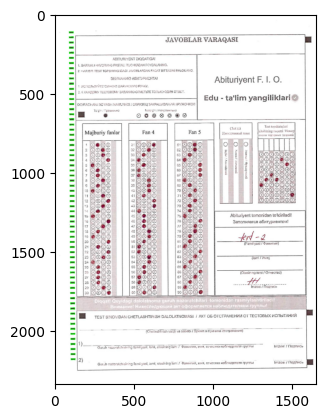

In [7]:
for i in [1,3,4,5,12,13,14,15,16]:
  image = cv2.imread(f"images/wrapped_origin/{i}.jpg")
  conturs = find_contours_of_base_rectangles(image)
  cv2.drawContours(image, conturs, -1, (0,255,0), 2)
  plt.imshow(image)

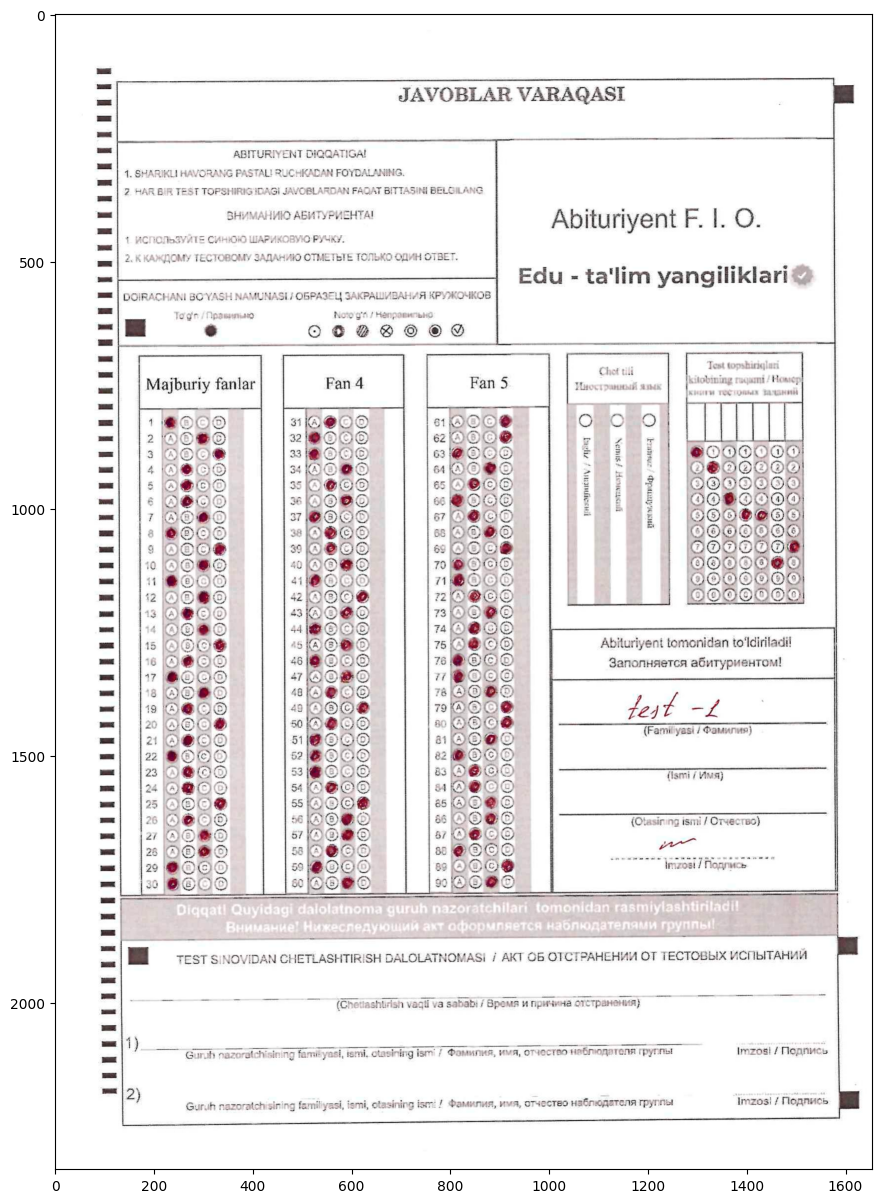

In [8]:
def create_circle_contour(x, y, r):
    """
    (x, y, r) formatidagi doira koordinatalari va radiusidan kontur yaratadi.

    Args:
    x (int): Doira markazining x koordinatasi.
    y (int): Doira markazining y koordinatasi.
    r (int): Doira radiusi.

    Returns:
    numpy.ndarray: Doira konturi.
    """
    circle_contour = []
    for angle in range(0, 360):
        theta = np.radians(angle)
        x_point = int(x + r * np.cos(theta))
        y_point = int(y + r * np.sin(theta))
        circle_contour.append([x_point, y_point])

    # Konturni numpy array formatiga o'tkazish
    circle_contour = np.array(circle_contour, dtype=np.int32).reshape((-1, 1, 2))
    return circle_contour

def draw_text_on_image(image, text, x, y):
    """
    Tasvirga berilgan koordinatalarda matn yozadi.

    Args:
    image (numpy.ndarray): Tasvir.
    text (str): Yoziladigan matn.
    x (int): Matn yoziladigan x koordinatasi.
    y (int): Matn yoziladigan y koordinatasi.
    """
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.5
    color = (0, 255, 0)  # Oq rang
    thickness = 2
    cv2.putText(image, text, (x, y), font, font_scale, color, thickness, cv2.LINE_AA)

def find_circles_hough(image):
    # Применение эрозии для улучшения видимости контуров
    # Преобразование изображения в оттенки серого
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Tasvirni teskari o'girish
    inverted_image = cv2.bitwise_not(gray)
    
    # Tasvirni yaxshilash uchun Gauss filtri orqali o'tkazish
    blurred_image = cv2.GaussianBlur(inverted_image, (9, 9), 2)
    
    # Hough Circle Transform yordamida aylanalarni topish
    circles = cv2.HoughCircles(blurred_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=30,
                            param1=50, param2=30, minRadius=16, maxRadius=30)
    filtered_circles = []
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            # Aylanani maska sifatida yaratish
            mask = np.zeros_like(image)
            cv2.circle(mask, (x, y), r, (255, 255, 255), -1)
            
            # Maskani qo'llash orqali aylanani ajratish
            masked_image = cv2.bitwise_and(image, mask)
            
            # Aylanadagi ranglarning o'rtacha qiymatini hisoblash
            mean_color = cv2.mean(image, mask=mask[:, :, 0])
            
            # Aylanani o'rtacha rang bilan to'ldirish
            if mean_color[2] < 100:
                draw_text_on_image(image, f"({int(mean_color[2])})", x+20,y)
                filtered_circles.append(create_circle_contour(x,y,r))
    return filtered_circles


image = cv2.imread("images/wrapped_origin/14.jpg")
cv2.drawContours(image, find_circles_hough(image), -1, (0,255,0), 2)
plt.figure(figsize=(20, 15))
plt.imshow(image)

In [21]:

def find_circle_contours(image, threshold_value=80, blur_kernel_size=(5, 5), erosion_kernel_size=(7, 7), aspect_ratio_range=(0.5, 2)):
    """
    Функция для нахождения контуров, похожих на круги.

    :param image: Входное изображение.
    :param threshold_value: Пороговое значение для бинаризации.
    :param blur_kernel_size: Размер ядра для Gaussian Blur.
    :param erosion_kernel_size: Размер ядра для эрозии.
    :param aspect_ratio_range: Допустимый диапазон соотношений сторон для определения круга.
    :return: Список контуров, похожих на круги.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Применение размытия (Gaussian Blur)
    blurred = cv2.GaussianBlur(gray, blur_kernel_size, 0)

    # Применение эрозии для улучшения видимости контуров
    kernel = np.ones(erosion_kernel_size, np.uint8)
    eroded = cv2.erode(blurred, kernel, iterations=1)

    # Применение порогового значения для выделения черных линий
    _, binary = cv2.threshold(eroded, threshold_value, 255, cv2.THRESH_BINARY_INV)
    
    # Поиск контуров
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Список для хранения контуров, похожих на круги
    circle_contours = []

    # Фильтрация контуров
    for contour in contours:
        # Аппроксимация контура
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Проверка количества углов
        if True:  # Условие для фильтрации контуров с небольшим количеством углов
            # Вычисление ограничивающего прямоугольника
            x, y, w, h = cv2.boundingRect(contour)
            
            # Проверка соотношения сторон, чтобы убедиться, что это похоже на круг
            aspect_ratio = float(w) / h
            if aspect_ratio_range[0] <= aspect_ratio <= aspect_ratio_range[1]:
                circle_contours.append(contour)

    return circle_contours

def analyze_all_contours(image, new_width, threshold = 120, kernel_size = (5,5), blur_size = (3,3)):
    # Yangi balandlikni hisoblash
    height, width = image.shape[:2]
    aspect_ratio = height / width
    new_height = int(new_width * aspect_ratio)
    
    # Rasmni resize qilish
    image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    circles = find_circle_contours(image, threshold, blur_size, kernel_size)
    leftmost_rect = find_contours_of_base_rectangles(image)
    # cv2.drawContours(image, circles, -1, (0,255,255), 2)
    
    # chap tomondagi to'rtburchaklarni aynan variantlar roparasidagisi
    left_contours = []
    for left_index in range(22,52):
        left_cnt = find_contour_by_y_order(leftmost_rect, left_index + 1)
        left_contours.append(left_cnt)
    # cv2.drawContours(image, left_contours, -1, (0,255,255), 2)
    
    # faqat chap tomondagi to'rtburchaklar bilan y o'qi bo'yicha kesishganlarini qoldiramiz
    finded_intersect_circles = []
    for left_cnt in left_contours:
        left_x, left_y, left_w, left_h = cv2.boundingRect(left_cnt)
        for circle_cnt in circles:
            circle_x, circle_y, circle_w, circle_h = cv2.boundingRect(circle_cnt)
            if is_intersects(left_y, left_h, circle_y, circle_h):
                finded_intersect_circles.append(circle_cnt)
    # cv2.drawContours(image, finded_intersect_circles, -1, (255,0,0), 2)
    
    # eni va bo'yi nisbati bo'yicha kvadratga o'xshashlarini qoldiramiz
    filtered_circles = []
    for circle_cnt in finded_intersect_circles:
        x,y,w,h = cv2.boundingRect(circle_cnt)
        if h != 0 and 0.4 <= float(w) / float(h) <= 2.0:
            filtered_circles.append(circle_cnt)
    
    # chap tomondagi konturlar bo'lsa ularni ham tozalab tashlaymiz
    filtered_circles = remove_intersections(filtered_circles, left_contours)
    
    # yuzalar nisbati orqali filterlaymiz
    filtered_circles_by_area_ratio = filter_by_area_ratio(filtered_circles,0.2,4,80)
    # cv2.drawContours(image, filtered_circles_by_area_ratio, -1, (0,255,255), 2)
    
    # kichkina nuqtalarni tozalab tashlaymiz
    filter_after_remove_small_contours = []
    for cnt in filtered_circles_by_area_ratio:
        current_cnt_area = cv2.contourArea(cnt)
        is_small = False
        for iteration_cnt in filtered_circles_by_area_ratio:
            iteration_cnt_area = cv2.contourArea(iteration_cnt)
            if  current_cnt_area != 0.0 and iteration_cnt_area / current_cnt_area > 3:
                is_small = True
                break
        if not is_small:
            filter_after_remove_small_contours.append(cnt)
    
    return image, filter_after_remove_small_contours, leftmost_rect

def filter_circle_iteration(image):
    result = []
    result_image = []
    result_left_contours = []
    is_finded = False
    for size in [500, 900, 1200]:
        for kernel_size in range(1,10):
            for threshold in range(80, 130):
                for blur_size in [(3,3), (5,5), (9,9)]:
                    imm, finded_circles, left_contours = analyze_all_contours(image, size, threshold, (kernel_size,kernel_size), blur_size)
                    if len(finded_circles) >= 97:
                        print(len(finded_circles))
                        result = finded_circles
                        result_image = imm
                        result_left_contours = left_contours
                        is_finded = True
                        break
                if is_finded:
                    break
            if is_finded:
                break
        if is_finded:
            break
    return result_image, result, result_left_contours

image = cv2.imread("images/wrapped_origin/16.jpg")
result_image, result_circles, result_left_contours = filter_circle_iteration(image)

def get_min_x(contour):
  x = cv2.boundingRect(contour)
  return x
answers = sorted(result_circles, key=get_min_x)[:90]

def get_answers(result_image, result_circles, result_left_contours, answers):
    col_counters = []
    col_counters.append([answers[0]])
    
    for i in range(1, len(answers)):
        cnt = answers[i]
        prev_cnt = answers[i - 1]
        x, y, w, h = cv2.boundingRect(cnt)
        prev_x, prev_y, prev_w, prev_h = cv2.boundingRect(prev_cnt)
        
        if  ((prev_x + prev_w - x) * 100) / w > 35:
          col_counters[len(col_counters) - 1].append(cnt)
        else:
          col_counters.append([cnt])
    
    left_counters = []
    for i in range(23, 53):
        left_counters.append(find_contour_by_y_order(result_left_contours, i))
    
    answer_cols = []
    for col_index in range(0, len(col_counters)):
        col = col_counters[col_index]
        for cnt in col:
          x,y,w,h = cv2.boundingRect(cnt)
          for row_index in range(0, len(left_counters)):
            left_counter = left_counters[row_index]
            row_x, row_y, row_w, row_h = cv2.boundingRect(left_counter)
            if intersection_length(y, y+h, row_y, row_y + row_h) > 0:
              answer_index = (col_index + 1) % 4
              answer_cols.append([row_index + ((math.ceil((col_index + 1.0) / 4.0)) - 1) * 30, answer_index])
    
    answer_cols = sorted(answer_cols, key=lambda x: x[0])
    return answer_cols

correct_answers = get_answers(result_image, result_circles, result_left_contours, answers)
print(correct_answers)

97
[[0, 2], [1, 3], [2, 3], [3, 0], [4, 1], [5, 2], [6, 2], [7, 3], [8, 2], [9, 1], [10, 3], [11, 0], [12, 3], [13, 2], [14, 1], [15, 0], [16, 3], [17, 2], [18, 1], [19, 0], [20, 2], [21, 0], [22, 3], [23, 1], [24, 2], [25, 2], [26, 2], [27, 2], [28, 3], [29, 0], [30, 0], [31, 3], [32, 2], [33, 1], [34, 2], [35, 1], [36, 1], [37, 3], [38, 3], [39, 3], [40, 2], [41, 0], [42, 0], [43, 1], [44, 2], [45, 2], [46, 2], [47, 3], [48, 3], [49, 2], [50, 1], [51, 1], [52, 3], [53, 3], [54, 2], [55, 2], [56, 1], [57, 1], [58, 0], [59, 2], [60, 3], [61, 3], [62, 2], [63, 1], [64, 0], [65, 0], [66, 0], [67, 1], [68, 2], [69, 3], [70, 2], [71, 3], [72, 2], [73, 2], [74, 1], [75, 0], [76, 3], [77, 3], [78, 2], [79, 2], [80, 1], [81, 0], [82, 3], [83, 2], [84, 1], [85, 0], [86, 3], [87, 2], [88, 1], [89, 0]]


In [9]:
# Функция для получения минимальной координаты x для каждого контура
def get_min_x(contour):
  x = cv2.boundingRect(contour)
  return x

In [10]:
def find_circles(image):
  leftmost_contours = find_contours_of_base_rectangles(image.copy())
  circle_contours = find_circle_contours(image.copy())
  not_intersections = remove_intersections(circle_contours, leftmost_contours)

  top_border_counter = find_contour_by_y_order(leftmost_contours, 22)
  filtered_counters = get_counters_after_counter(not_intersections, top_border_counter, 'y')
  filtered_counters = get_counters_after_counter(filtered_counters, top_border_counter, 'x')

  bottom_border_counter = find_contour_by_y_order(leftmost_contours, 53)
  filtered_counters = get_counters_before_counter(filtered_counters, bottom_border_counter, 'y')


  # Массив для хранения пересечений по оси Y
  intersections_y = []

  for base_counter in leftmost_contours:
      # Получаем bounding box для базового контура
      x_base, y_base, w_base, h_base = cv2.boundingRect(base_counter)
      
      for filtered_counter in filtered_counters:
          # Получаем bounding box для фильтрованного контура
          x_filtered, y_filtered, w_filtered, h_filtered = cv2.boundingRect(filtered_counter)
          
          # Проверка пересечения по оси Y
          if (y_base <= y_filtered <= y_base + h_base) or (y_filtered <= y_base <= y_filtered + h_filtered):
              intersections_y.append(filtered_counter)

  filtered_counters = intersections_y
  # Сортировка контуров по площади в порядке убывания
  sorted_counters = sorted(filtered_counters, key=cv2.contourArea, reverse=True)

  # Взятие первых 97 контуров
  top_97_counters = sorted_counters[:97]



  # Сортировка контуров по минимальной координате x в порядке возрастания
  sorted_by_x = sorted(top_97_counters, key=get_min_x)

  # Взятие самых левых 90 контуров
  leftmost_90_counters = sorted_by_x[:90]

  col_counters = []
  col_counters.append([leftmost_90_counters[0]])

  for i in range(1, len(leftmost_90_counters)):
    cnt = leftmost_90_counters[i]
    prev_cnt = leftmost_90_counters[i - 1]
    x, y, w, h = cv2.boundingRect(cnt)
    prev_x, prev_y, prev_w, prev_h = cv2.boundingRect(prev_cnt)

    if  ((prev_x + prev_w - x) * 100) / w > 35:
      col_counters[len(col_counters) - 1].append(cnt)
    else:
      col_counters.append([cnt])

  left_counters = []
  for i in range(23, 53):
    left_counters.append(find_contour_by_y_order(leftmost_contours, i))

  answer_cols = []
  for col_index in range(0, len(col_counters)):
    col = col_counters[col_index]
    for cnt in col:
      x,y,w,h = cv2.boundingRect(cnt)
      for row_index in range(0, len(left_counters)):
        left_counter = left_counters[row_index]
        row_x, row_y, row_w, row_h = cv2.boundingRect(left_counter)
        if intersection_length(y, y+h, row_y, row_y + row_h) > 0:
          answer_index = (col_index + 1) % 4
          answer_cols.append([row_index + ((math.ceil((col_index + 1.0) / 4.0)) - 1) * 30, answer_index])

  answer_cols = sorted(answer_cols, key=lambda x: x[0])
  return answer_cols

In [11]:
image = cv2.imread(f"./images/wrapped_origin/1.jpg")
answers = find_circles(image)
print(answers)

[[0, 2], [1, 3], [2, 1], [3, 0], [4, 3], [5, 2], [6, 2], [7, 1], [8, 3], [9, 0], [10, 2], [11, 0], [12, 3], [13, 1], [14, 0], [15, 2], [16, 0], [17, 1], [18, 3], [19, 2], [20, 2], [21, 3], [22, 1], [23, 0], [24, 2], [25, 3], [26, 1], [27, 0], [28, 2], [29, 3], [30, 1], [31, 3], [32, 2], [33, 0], [34, 1], [35, 3], [36, 2], [37, 0], [38, 1], [39, 3], [40, 2], [41, 0], [42, 1], [43, 3], [44, 2], [45, 0], [46, 1], [47, 3], [48, 2], [49, 0], [50, 2], [51, 1], [52, 3], [53, 2], [54, 1], [55, 0], [56, 2], [57, 3], [58, 2], [59, 0], [60, 1], [61, 3], [62, 1], [63, 3], [64, 1], [65, 0], [66, 2], [67, 3], [68, 0], [69, 1], [70, 2], [71, 3], [72, 1], [73, 3], [74, 2], [75, 3], [76, 2], [77, 0], [78, 1], [79, 3], [80, 1], [81, 3], [82, 2], [83, 0], [84, 3], [85, 2], [86, 0], [87, 3], [88, 2], [89, 1]]


In [20]:
for a in range(23,30):
    print(a)

23
24
25
26
27
28
29
